In [1]:
import pandas as pd
import numpy as np
import pickle
from matplotlib import pyplot as plt
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
import time
import random

In [2]:
f = open('./dataset_OSAS-window-20.pkl', 'rb')
data_ecg = pickle.load(f)                                
f.close()

In [3]:
f = open('./psg_ecg_all_features.pkl', 'rb')
data_psg = pickle.load(f)                                
f.close()

In [4]:
print(data_psg.columns)

Index(['y', 'patient', 'PSG_Flow_std', 'PSG_Flow_rms', 'PSG_Flow_med',
       'PSG_Thorax_std', 'PSG_Thorax_rms', 'PSG_Thorax_med', 'PSG_Abdomen_std',
       'PSG_Abdomen_rms', 'PSG_Abdomen_med', 'signal_ecg_i_std',
       'signal_ecg_i_rms', 'signal_ecg_i_med', 'signal_ecg_ii_std',
       'signal_ecg_ii_rms', 'signal_ecg_ii_med'],
      dtype='object')


In [5]:
#Specify features for each
features_psg_std = ['PSG_Flow_std', 'PSG_Thorax_std', 'PSG_Abdomen_std']
features_psg_rms = ['PSG_Flow_rms', 'PSG_Thorax_rms', 'PSG_Abdomen_rms']
features_psg_med = ['PSG_Flow_med', 'PSG_Thorax_med', 'PSG_Abdomen_med']
features_ecg_ecg = ['signal_ecg_i_std',
                    'signal_ecg_i_rms', 'signal_ecg_i_med', 'signal_ecg_ii_std',
                    'signal_ecg_ii_rms', 'signal_ecg_ii_med']

features_psg_all = features_psg_std + features_psg_rms + features_psg_med

features_ecg = ['signal_ecg_i_std', 'signal_ecg_i_NN50_1', 
            'signal_ecg_i_NN50_2', 'signal_ecg_i_pNN50_1', 
            'signal_ecg_i_pNN50_2', 'signal_ecg_i_median', 
            'signal_ecg_i_rmsd', 'signal_ecg_i_iqr', 
            
            'signal_ecg_ii_std', 'signal_ecg_ii_NN50_1', 
            'signal_ecg_ii_NN50_2', 'signal_ecg_ii_pNN50_1', 
            'signal_ecg_ii_pNN50_2', 'signal_ecg_ii_median', 
            'signal_ecg_ii_rmsd', 'signal_ecg_ii_iqr',
            
            'signal_ecg_iii_std', 'signal_ecg_iii_NN50_1', 
            'signal_ecg_iii_NN50_2', 'signal_ecg_iii_pNN50_1', 
            'signal_ecg_iii_pNN50_2', 'signal_ecg_iii_median', 
            'signal_ecg_iii_rmsd', 'signal_ecg_iii_iqr' ]

In [6]:
def run_SVM( X, Y, X_t, y_t):
    a=time.time()
    clf = svm.SVC(kernel='rbf')
    clf.fit(X, y)
    b = time.time()
    print("Completed model in ", ( b - a ) / 60, " minutes")
    
    return clf

In [7]:
### Split the training data and testing data
patient_ids = np.unique(data_ecg['patient'])
patient_count = len(patient_ids)

training_count = int(patient_count * .8)
testing_count = int(patient_count * .2)

assert( (training_count + testing_count) == patient_count)

## Break out the patients
training_patients = patient_ids[:training_count]
testing_patients = patient_ids[training_count:]

training_data_set = np.array([])

In [8]:
## Rips the nans and returns the training/labels and testing/labels
def rip_nans_split( training_patients, testing_patients, data, features):
    X = []
    y = []
    
    if 'anomaly' in data.columns:
        labelid = 'anomaly'
    else:
        labelid = 'y'
        
    for pid in training_patients:
        patient = data[data['patient'] == pid]
        
        for i, row in patient.iterrows():
            feats = row[features].values.tolist()
            
            if any(np.isnan(val) for val in feats):
                continue
                
            X.append(feats)
            
            label = 1 if row[labelid] else 0
        
            y.append(label)
        
    undersample = NearMiss(version=1, n_neighbors=3)
    #undersample = CondensedNearestNeighbour(n_neighbors=1)
    print(sum(y))
    X, y = undersample.fit_resample(X, y)
    
    X = StandardScaler().fit_transform(X)
    
    X_t = []
    y_t = []
    
    for pid in testing_patients:
        patient = data[data['patient'] == pid]
        
        for i, row in patient.iterrows():
            feats = row[features].values.tolist()
            
            if any(np.isnan(val) for val in feats):
                continue
                
            X_t.append(feats)
            
            label = 1 if row[labelid] else 0
            
            y_t.append(label)
            
    X_t = StandardScaler().fit_transform(X_t)

    return (X,y,X_t,y_t)

21202
About to run SVM
Completed model in  0.629568628470103  minutes
              precision    recall  f1-score   support

           0       0.83      0.45      0.58     13987
           1       0.23      0.63      0.34      3650

    accuracy                           0.49     17637
   macro avg       0.53      0.54      0.46     17637
weighted avg       0.70      0.49      0.53     17637



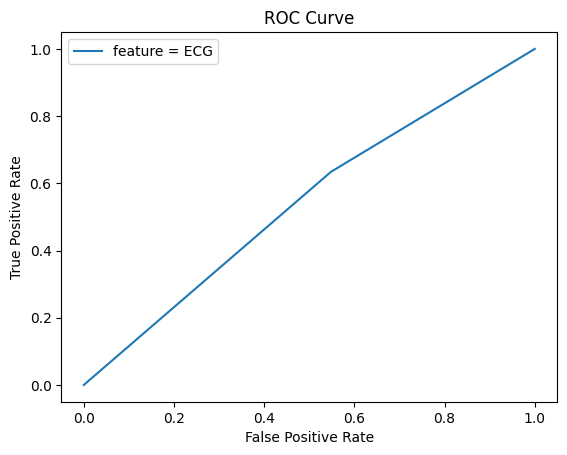

In [10]:
## Run SVM for ecg features
X,y,X_t,y_t = rip_nans_split( training_patients, testing_patients, data_ecg, features_ecg)

print("About to run SVM")

clf = run_SVM(X, y, X_t, y_t)

Y_pred_ecg = clf.predict(X_t)
report = classification_report(y_t, Y_pred_ecg)
print(report)

## Roc Curve
fpr, tpr, thresholds = roc_curve(y_t, Y_pred_ecg)
plt.plot(fpr, tpr, '-', label = "feature = ECG")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()

What follows is the training for the PSG/EGC std/mean/rmsd data

In [11]:
## Split training and testing data
pos_events = data_psg[ data_psg['y'] == 1.0].reset_index(drop=True)

all_neg_events = data_psg[ data_psg['y'] == 0.0].reset_index(drop=True)
neg_events = all_neg_events[:len(pos_events)]

trainlen = int( len(pos_events) * .8)
testlen = trainlen = int( len(pos_events) * .2)

training_data = pd.concat([neg_events[:trainlen], pos_events[:trainlen]], ignore_index=True)
testing_data = pd.concat([neg_events[trainlen:], pos_events[trainlen:]], ignore_index=True)

In [12]:
## Run SVM for PSG std features
X = training_data[features_psg_std]
y = training_data['y']

X_t = testing_data[features_psg_std]
y_t = testing_data['y']

print("About to run SVM")

clf = run_SVM(X, y, X_t, y_t)

Y_pred_psg_std = clf.predict(X_t)
report = classification_report(y_t, Y_pred_psg_std)
print(report)

About to run SVM
Completed model in  0.032973074913024904  minutes
              precision    recall  f1-score   support

         0.0       0.61      0.84      0.71     16885
         1.0       0.74      0.45      0.56     16885

    accuracy                           0.65     33770
   macro avg       0.67      0.65      0.63     33770
weighted avg       0.67      0.65      0.63     33770



In [13]:
## Run SVM for PSG rms features
X = training_data[features_psg_rms]
y = training_data['y']

X_t = testing_data[features_psg_rms]
y_t = testing_data['y']

print("About to run SVM")

clf = run_SVM(X, y, X_t, y_t)

Y_pred_psg_rms = clf.predict(X_t)
report = classification_report(y_t, Y_pred_psg_rms)
print(report)

About to run SVM
Completed model in  0.027884121735890707  minutes
              precision    recall  f1-score   support

         0.0       0.61      0.87      0.72     16885
         1.0       0.77      0.43      0.56     16885

    accuracy                           0.65     33770
   macro avg       0.69      0.65      0.64     33770
weighted avg       0.69      0.65      0.64     33770



In [14]:
## Run SVM for PSG median features
X = training_data[features_psg_med]
y = training_data['y']

X_t = testing_data[features_psg_med]
y_t = testing_data['y']

print("About to run SVM")

clf = run_SVM(X, y, X_t, y_t)

Y_pred_psg_med = clf.predict(X_t)
report = classification_report(y_t, Y_pred_psg_med)
print(report)

About to run SVM
Completed model in  0.02756845553716024  minutes
              precision    recall  f1-score   support

         0.0       0.62      0.82      0.70     16885
         1.0       0.73      0.49      0.58     16885

    accuracy                           0.65     33770
   macro avg       0.67      0.65      0.64     33770
weighted avg       0.67      0.65      0.64     33770



In [15]:
## Run SVM for ECG features
X = training_data[features_ecg_ecg]
y = training_data['y']

X_t = testing_data[features_ecg_ecg]
y_t = testing_data['y']

print("About to run SVM")

clf = run_SVM(X, y, X_t, y_t)

Y_pred_ecg_ecg = clf.predict(X_t)
report = classification_report(y_t, Y_pred_ecg_ecg)
print(report)

About to run SVM
Completed model in  0.03149136702219645  minutes
              precision    recall  f1-score   support

         0.0       0.53      0.88      0.66     16885
         1.0       0.65      0.22      0.33     16885

    accuracy                           0.55     33770
   macro avg       0.59      0.55      0.49     33770
weighted avg       0.59      0.55      0.49     33770



In [16]:
## Run SVM for All psg
X = training_data[features_psg_all]
y = training_data['y']

X_t = testing_data[features_psg_all]
y_t = testing_data['y']

print("About to run SVM")

clf = run_SVM(X, y, X_t, y_t)

Y_pred_psg_all = clf.predict(X_t)
report = classification_report(y_t, Y_pred_psg_all)
print(report)

About to run SVM
Completed model in  0.028830444812774657  minutes
              precision    recall  f1-score   support

         0.0       0.61      0.86      0.71     16885
         1.0       0.76      0.46      0.57     16885

    accuracy                           0.66     33770
   macro avg       0.69      0.66      0.64     33770
weighted avg       0.69      0.66      0.64     33770



In [17]:
## Run SVM for All psg and ecg
X = training_data[features_psg_all + features_ecg_ecg]
y = training_data['y']

X_t = testing_data[features_psg_all + features_ecg_ecg]
y_t = testing_data['y']

print("About to run SVM")

clf = run_SVM(X, y, X_t, y_t)

Y_pred_psg_ecg = clf.predict(X_t)
report = classification_report(y_t, Y_pred_psg_ecg)
print(report)

About to run SVM
Completed model in  0.03592577377955119  minutes
              precision    recall  f1-score   support

         0.0       0.60      0.86      0.71     16885
         1.0       0.75      0.43      0.55     16885

    accuracy                           0.64     33770
   macro avg       0.68      0.64      0.63     33770
weighted avg       0.68      0.64      0.63     33770



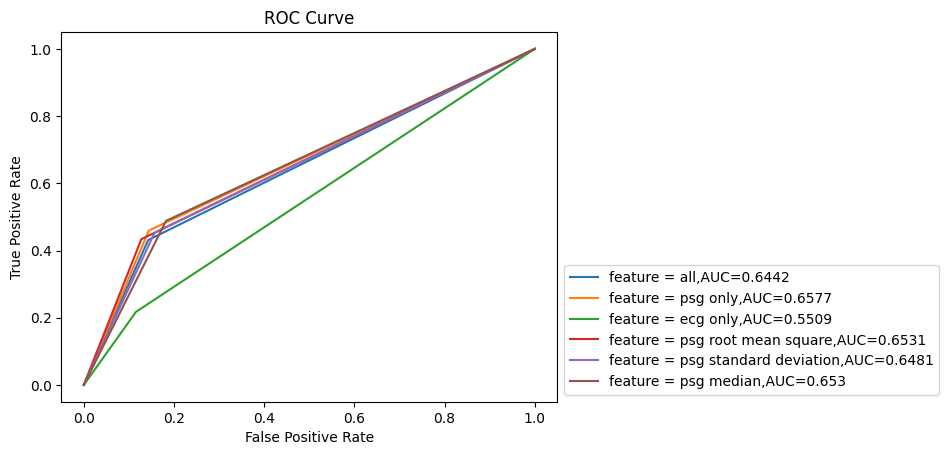

In [18]:
all_pred = [Y_pred_psg_ecg, Y_pred_psg_all, Y_pred_ecg_ecg, Y_pred_psg_rms, Y_pred_psg_std, Y_pred_psg_med  ]
tests = ['all', 'psg only', 'ecg only', 'psg root mean square', 'psg standard deviation', 'psg median', ]

#set up plotting area
plt.figure(0).clf()

for i in range(len(all_pred)):
    fpr, tpr, _ = roc_curve(y_t, all_pred[i])
    auc = round(roc_auc_score(y_t, all_pred[i]), 4)
    plt.plot(fpr,tpr,label="feature = " + tests[i] + ",AUC="+str(auc))

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(bbox_to_anchor=(1,0), loc="lower left")
plt.show()